## Load the libraries

In [41]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

<h2 id="load_dataset">Load the data</h2>

In [42]:
#Here we will load from github or do API or something

## Load Data From CSV File


<span style="color:red;">Welcome to Alpha Vantage! Here is your API key: 9NNSMISKUYVUTO0M. Please record this API key at a safe place for future data access.</span>
from tvDatafeed import TvDatafeed, Interval

username = 'pkongdan01'
password = 'Secu@3545'

tv = TvDatafeed(username, password)

In [43]:
# load the data
xau23 = pd.read_csv("./data/xau23.csv", header=None)
xau22 = pd.read_csv("./data/xau22.csv", header=None)
xau21 = pd.read_csv("./data/xau21.csv", header=None)

# create a columns name
cname= ["date","sec","open", "high", "low", "close","volume"]
xau23.columns = cname
xau22.columns = cname
xau21.columns = cname

# union the data set 
xau_data = pd.concat([xau23,xau22,xau21])
print(xau_data.head())

# Check for N/A
print(xau_data.isna().sum())
# Check for types
print(xau_data.dtypes)

         date    sec      open      high       low     close  volume
0  2023.01.02  18:00  1826.837  1827.337  1826.617  1826.637       0
1  2023.01.02  18:01  1826.537  1827.357  1826.137  1826.537       0
2  2023.01.02  18:02  1826.137  1826.737  1826.137  1826.737       0
3  2023.01.02  18:05  1827.187  1828.867  1827.187  1828.738       0
4  2023.01.02  18:06  1828.758  1829.958  1828.758  1829.497       0
date      0
sec       0
open      0
high      0
low       0
close     0
volume    0
dtype: int64
date       object
sec        object
open      float64
high      float64
low       float64
close     float64
volume      int64
dtype: object


## Data Processing

#### Adding datetime format

In [44]:
# combine the date and time columns into a single string
xau_data['datetime'] = xau_data['date'] + xau_data['sec']

# convert the combined string to a Pandas datetime object
xau_data['datetime'] = pd.to_datetime(xau_data['datetime'], format = '%Y.%m.%d%H:%M')

# reselect the data
xau_data = xau_data[['datetime','open','high','low','close','volume']]

# sort the data ascending
xau_data = xau_data.sort_values(by='datetime',ascending=True)

print(xau_data.dtypes)

datetime    datetime64[ns]
open               float64
high               float64
low                float64
close              float64
volume               int64
dtype: object


#### Resampling into 1 hour interval

In [45]:
# set the datetime column as the index
xau_data.set_index('datetime', inplace=True)

# resample data into 1hour interval
xau_data = xau_data.resample('1H').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last','volume':'sum'})

print(xau_data.isnull().sum())

# drop null value (Market Close on those days)
xau_data = xau_data.dropna()
print(xau_data.isnull().sum())

print(len(xau_data))
print(xau_data.head())

df = xau_data
highs = df['high'].rolling(window=4).max().shift(-4)
lows = df['low'].rolling(window=4).max().shift(-4)
# create new columns for conditions 
df['high_close_diff'] = highs - df['close']
df['low_close_diff'] = lows - df['close']
df = df.dropna()

open      6170
high      6170
low       6170
close     6170
volume       0
dtype: int64
open      0
high      0
low       0
close     0
volume    0
dtype: int64
12700
                         open      high       low     close  volume
datetime                                                           
2021-01-03 18:00:00  1904.998  1914.858  1903.288  1913.035       0
2021-01-03 19:00:00  1913.025  1913.508  1909.858  1913.278       0
2021-01-03 20:00:00  1913.278  1918.655  1912.124  1916.524       0
2021-01-03 21:00:00  1916.558  1921.775  1915.394  1921.675       0
2021-01-03 22:00:00  1921.695  1925.145  1920.675  1923.120       0


#### Adding Condition for y

In [46]:
def reco(row):
    if row.low_close_diff <= -3.3:
        return 0
    elif row.high_close_diff >= 4.3: #I use 3 plus .3 for bit offer off-set, and 1 in case of delay ordering cause price to change.
        return 1
    else:
        return 0

df['target'] = df.apply(reco,axis=1)

df_simu = df
print('1', (df['target'] == 1).sum())
print('0', (df['target'] == 0).sum())

df = df[['open','high','low','close','target']]

1 5057
0 7639


C:\Users\pkong\AppData\Local\Temp\ipykernel_1788\3014901381.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = df.apply(reco,axis=1)


In [47]:
# df["mhigh"]=highs
# df["mlow"]=lows
# df.to_csv("audit.csv")
(df['target'] == 1).sum()

5057

In [48]:
# df2.to_csv('df2.csv')

In [49]:
# df.to_csv('df.csv')

#### Making Training, Cross Validation, and Testing sets

In [50]:
n = len(df)
print(n)

train_n = int(round(n*0.65,0))
print('number of training set: ', train_n)

cross_n = int(round(n*0.20,0))
print('number of cross validation set: ', cross_n)

test_n = int(round(n*0.15,0))
print('number of test set: ', test_n)

print('sum', train_n + cross_n + test_n)


train_start = str(df.iloc[0].name)
train_end = str(df.iloc[train_n].name)
print('Training set start: {0} \n Training set end: {1}'.format(train_start,train_end))
#print(df.loc[train_start:train_end])

cross_start = str(df.iloc[train_n+1].name)
cross_end = str(df.iloc[train_n+cross_n].name)
print('cross validation set start: {0} \n cross validation set end: {1}'.format(cross_start,cross_end))
#print(df.loc[cross_start:cross_end])

test_start = str(df.iloc[train_n + cross_n +1].name)
test_end = str(df.iloc[n-1].name)
print('test set start: {0} \n test set end: {1}'.format(test_start,test_end))
#print(df.loc[test_start:])

X = df.drop(['target'], axis=1)

y = df['target']


X_train = np.asarray(X.loc[train_start:train_end])
y_train = np.asarray(y.loc[train_start:train_end])

X_cross = np.asarray(X.loc[cross_start:cross_end])
y_cross = np.asarray(y.loc[cross_start:cross_end])

X_test = np.asarray(X.loc[test_start:])
y_test =np.asarray(y.loc[test_start:])



#Extra for GridSearch
X_train_cv = np.asarray(X.loc[train_start:cross_end])
y_train_cv = np.asarray(y.loc[train_start:cross_end])


print("Shape of X_train:", np.shape(X_train))
print("Shape of y_train:", np.shape(y_train))
print("Shape of X_cross:", np.shape(X_cross))
print("Shape of y_cross:", np.shape(y_cross))
print("Shape of X_test:", np.shape(X_test))
print("Shape of y_test:", np.shape(y_test))


# Below is for later simulation
df_simu_test = df_simu.loc[test_start:]

12696
number of training set:  8252
number of cross validation set:  2539
number of test set:  1904
sum 12695
Training set start: 2021-01-03 18:00:00 
 Training set end: 2022-05-26 16:00:00
cross validation set start: 2022-05-26 18:00:00 
 cross validation set end: 2022-10-28 10:00:00
test set start: 2022-10-28 11:00:00 
 test set end: 2023-02-28 19:00:00
Shape of X_train: (8253, 4)
Shape of y_train: (8253,)
Shape of X_cross: (2539, 4)
Shape of y_cross: (2539,)
Shape of X_test: (1904, 4)
Shape of y_test: (1904,)


####เอาไว้เรียนรู้ทำความเข้าใจ ตรงนี้สำคัญ ยากและลืมง่าย

#Create a sample dataframe
df = pd.DataFrame({'value': [2, 4, 5, 7, 6, 8, 9, 10, 11, 12, 9, 8, 6, 4, 3]})

#Apply rolling window with current row included and apply max function
window_period = 4
df['rolling_min'] = df['value'].rolling(window=4).min().shift(-3)
df['rolling_max'] = df['value'].rolling(window=4).max().shift(-3)
df


In [51]:
#Create Normalized Data
def normalize_data(X):
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)
    X_norm = (X - means) / stds
    return X_norm, means, stds

#This can run multiple times
X_train_n, X_train_means, X_train_stds = normalize_data(X_train)

def normalize_data_new(X,means,stds):
    X_norm = (X - means) / stds
    return X_norm

X_cross_n = normalize_data_new(X_cross,X_train_means,X_train_stds)
X_test_n = normalize_data_new(X_test,X_train_means,X_train_stds)

##### Export Scaler

In [52]:
from joblib import dump
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(sum(X_test_n == X_test_scaled)) # sum if true

dump(scaler, 'scaler_long.pkl')

[1904 1904 1904 1904]


['scaler_long.pkl']

##### Test import scaler

In [53]:
from joblib import load
scaler2 = load('scaler_long.pkl')
X_test_scaled2 = scaler2.transform(X_test)
sum((X_test_n == X_test_scaled2) & (X_test_scaled == X_test_scaled2))

array([1904, 1904, 1904, 1904])

##### Final verification

In [54]:
mean = scaler.mean_
std = scaler.scale_
mean2 = scaler2.mean_
std2 = scaler2.scale_
print('mean scaler one',mean)
print('mean scaler two',mean2)
print('mean manual nor',X_train_means)

print('std scaler one',std)
print('std scaler two',std2)
print('std manual nor',X_train_stds)



mean scaler one [1823.18836217 1825.47507294 1820.76072604 1823.17453471]
mean scaler two [1823.18836217 1825.47507294 1820.76072604 1823.17453471]
mean manual nor [1823.18836217 1825.47507294 1820.76072604 1823.17453471]
std scaler one [64.70528984 65.0129833  64.36380578 64.69964992]
std scaler two [64.70528984 65.0129833  64.36380578 64.69964992]
std manual nor [64.70528984 65.0129833  64.36380578 64.69964992]


<h2 id="modeling">Modeling (SVM with Scikit-learn)</h2>


In the context of Support Vector Machines (SVM), "C" is a hyperparameter that controls the trade-off between maximizing the margin and minimizing the classification error on the training data.

The hyperparameter "C" in SVM controls the misclassification penalty. A smaller value of "C" allows more misclassifications on the training data, while a larger value of "C" penalizes misclassifications more heavily. In other words, a smaller value of "C" creates a wider margin, allowing more data points to fall within the margin, but may result in lower accuracy on the training data. Conversely, a larger value of "C" creates a narrower margin, reducing the number of misclassifications but may lead to overfitting.

<span style="color:red">
Large C >>> Larger penalizes >>> complex model >>> lead to overfittting <br>
Small C >>> Smaller penalizes >>> simple model >>> underfitting
</span>

## MODEL 1: LSVM

In [67]:
print((y_cross == 0).sum() /((y_cross == 1).sum() + (y_cross == 0).sum() ))
print((y_cross == 1).sum())
print((y_cross == 0).sum())

0.6187475384009452
968
1571


C=0.001, Train score=0.6022052586938084, cross score=0.6187475384009452
C=0.01, Train score=0.6030534351145038, cross score=0.6187475384009452
C=0.1, Train score=0.6074154852780806, cross score=0.6199291059472233
C=0.5, Train score=0.6116563673815583, cross score=0.6226860968885388
C=1, Train score=0.6131103841027505, cross score=0.6234738085860575
C=1.5, Train score=0.6129892160426511, cross score=0.6230799527372981
C=2, Train score=0.6127468799224525, cross score=0.6222922410397794
C=10, Train score=0.6118987035017569, cross score=0.6222922410397794


c:\Users\pkong\LSVM-XAUUSD\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


C=100, Train score=0.6117775354416576, cross score=0.6222922410397794
The best 'C' is: 1
score: 0.62
Accuracy_score:  0.62
weight avg 0.51
jaccard:  0.06
              precision    recall  f1-score   support

           0       0.63      0.97      0.76      1571
           1       0.56      0.06      0.11       968

    accuracy                           0.62      2539
   macro avg       0.59      0.52      0.43      2539
weighted avg       0.60      0.62      0.51      2539



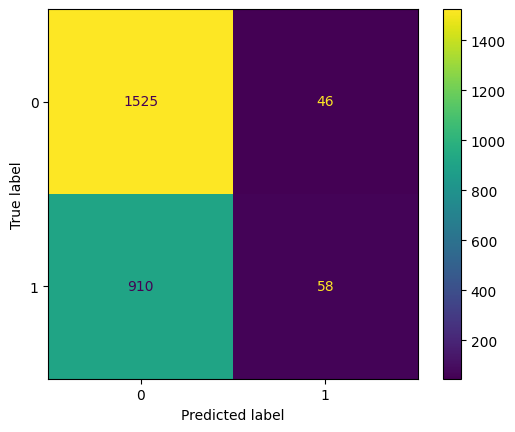

In [56]:
# Define a list of hyperparameters to loop through
#################larger value of C imposes less regularization on the model
Cs = [0.001,0.01, 0.1,0.5, 1, 1.5, 2, 10,100]

# Initialize variables to keep track of the best hyperparameters and their corresponding score
best_score = 0
best_C = None
max_iter = 20000
features_X_train = X_train_n
target_y_train = y_train
features_X_cross = X_cross_n
target_y_cross = y_cross
# Loop through the hyperparameters
for C in Cs:
    lsvm = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, C=C, max_iter=max_iter)
    lsvm.fit(X_train_n, y_train)
    train_score = lsvm.score(features_X_train, target_y_train)
    cross_score = lsvm.score(features_X_cross, target_y_cross)
    print(f"C={C}, Train score={train_score}, cross score={cross_score}")
    
    # Update the best hyperparameters and their corresponding score if applicable
    if train_score > best_score:
        best_score = train_score
        best_C = C

print("The best 'C' is:", best_C)
# Create the LinearSVC model with normalization and the best value of C
lsvm = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, C=best_C, max_iter=max_iter)

# Fit the model to the training data
lsvm.fit(features_X_train, target_y_train)


#EVALUATION
test_score = round(lsvm.score(features_X_cross, target_y_cross),2)
print("score:", test_score)


yhat_m1 = lsvm.predict(features_X_cross)
accuracy_m1 = round(accuracy_score(target_y_cross,yhat_m1),2)
print('Accuracy_score: ', accuracy_m1)

f1 = round(f1_score(target_y_cross, yhat_m1, average='weighted'), 2)
print('weight avg', f1)

jaccard = round(jaccard_score(target_y_cross, yhat_m1,pos_label=1),2)
print('jaccard: ', jaccard)

print(metrics.classification_report(target_y_cross, yhat_m1))


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_estimator(lsvm, features_X_cross, target_y_cross)


In [57]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, randint # this will indirectly use in TimeSeriesSplit

# Define the hyperparameter space
param_dist = {'n_estimators': [100, 200, 300],
              'max_depth': [3, 6, 9],
              'gamma': [0.01, 0.1],
              'learning_rate': [0.001, 0.01, 0.1, 1],
              'reg_lambda': [0.1, 1, 10],
              'reg_alpha': [0.1, 1, 10]}

def count_hyperparam_combinations(param_dict):
    total_combinations = 1
    for key in param_dict:
        total_combinations *= len(param_dict[key])
    return total_combinations

possible_combination = count_hyperparam_combinations(param_dist)
print("possible combination:", possible_combination)


# Create a time series split object
tscv = TimeSeriesSplit(n_splits=5)

# Scale the training data
scaler = StandardScaler()
features_X_train = scaler.fit_transform(X_train)
target_y_train = y_train



# Create a random search object
model_xgb = xgb.XGBRegressor(seed=42) # set seed to 42 to fix how model randomize sets of cv, this is for reproducibility.
random_search = RandomizedSearchCV(model_xgb, param_distributions=param_dist, cv=tscv, n_iter=possible_combination-(possible_combination*0.8), verbose=1, n_jobs=-1)

# Fit the random search object to the data
random_search.fit(features_X_train, target_y_train)

# Print the best hyperparameters found by the random search
print(random_search.best_params_)

# Create the final model using the best hyperparameters
model_xgb = xgb.XGBRegressor(seed=42, **random_search.best_params_)


# Fit the final model to the training data
model_xgb.fit(features_X_train, y_train)


possible combination: 648
Fitting 5 folds for each of 129 candidates, totalling 645 fits
{'reg_lambda': 10, 'reg_alpha': 0.1, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.1}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Accuracy score: 0.5636077195746357
F1 score: 0.5608237726818395
Jaccard score: 0.2578700602813128
              precision    recall  f1-score   support

           0       0.64      0.67      0.65      1571
           1       0.42      0.40      0.41       968

    accuracy                           0.56      2539
   macro avg       0.53      0.53      0.53      2539
weighted avg       0.56      0.56      0.56      2539



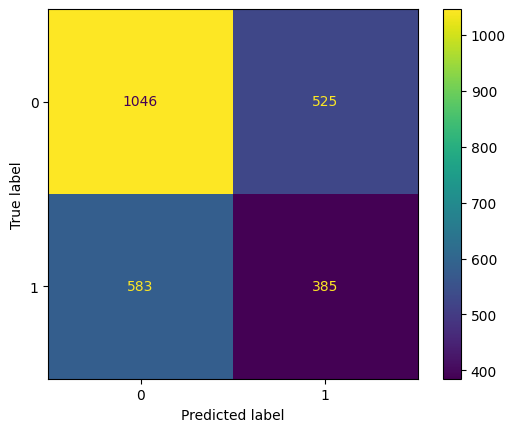

In [58]:
# Normalize the test data using the same scaler used for training data
features_X_cross = scaler.transform(X_cross)
target_y_cross = y_cross

# Make predictions using the XGBoost model
yhat_m2_pred = model_xgb.predict(features_X_cross)

# Convert the predicted values to binary labels (0 or 1) using a threshold of 0.5
yhat_m2 = (yhat_m2_pred > 0.5).astype(int)

# Evaluate the model performance on the test set
accuracy = accuracy_score(target_y_cross, yhat_m2)
f1 = f1_score(target_y_cross, yhat_m2, average='weighted')
jaccard = jaccard_score(target_y_cross, yhat_m2)

# Print the evaluation metrics
print("Accuracy score:", accuracy)
print("F1 score:", f1)
print("Jaccard score:", jaccard)



# Make predictions using the XGBoost model
yhat_m2_pred = model_xgb.predict(features_X_cross)

# Convert the predicted values to binary labels (0 or 1) using a threshold of 0.5
yhat_m2 = (yhat_m2_pred > 0.5).astype(int)

#report
print(metrics.classification_report(target_y_cross, yhat_m2))

# Plot the confusion matrix
cm = confusion_matrix(target_y_cross, yhat_m2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(target_y_cross))
disp.plot()


In [59]:
# Mad man method loop through everything
#   larger value of C imposes less regularization on the model
params = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2']}
lr = LogisticRegression(solver='liblinear')
best_score_no_norm = 0
best_params = {}

features_X_train = X_train
target_y_train = y_train
features_X_cross = X_cross
target_y_cross = y_cross

for c in params['C']:
    for p in params['penalty']:
        lr.set_params(C=c, penalty=p)
        lr.fit(features_X_train, target_y_train)
        score_train = lr.score(features_X_train,target_y_train)
        score_cross = lr.score(features_X_cross, target_y_cross)
        print("score_train: {0}, score_cross: {1}, C: {2}, penalty: {3}".format(score_train,score_cross,c,p))
        if score_train > best_score_no_norm:
            best_score_no_norm = score_train
            best_params_no_norm = {'C': c, 'penalty': p}
print("Without Normalization")
print("Best hyperparameters:", best_params_no_norm)
print("Cross set score:", best_score_no_norm)

#------------

lr = LogisticRegression(solver='liblinear')
best_score_norm = 0
best_params_norm = {}

features_X_train = X_train_n
target_y_train = y_train
features_X_cross = X_cross_n
target_y_cross = y_cross

for c in params['C']:
    for p in params['penalty']:
        
        lr.set_params(C=c, penalty=p)
        lr.fit(features_X_train, target_y_train)
        
        score_train = lr.score(features_X_train,target_y_train)
        score_cross = lr.score(features_X_cross, target_y_cross)
        print("score_train: {0}, score_cross: {1}, C: {2}, penalty: {3}".format(score_train,score_cross,c,p))
        if score_train > best_score_norm:
            best_score_norm = score_train
            best_params_norm = {'C': c, 'penalty': p}
print("With Normalization")
print("Best hyperparameters:", best_params_norm)
print("Cross set score:", best_score_norm)

if best_score_no_norm >= best_score_norm:
    best_params = best_params_no_norm
    features_X_train = X_train
    target_y_train = y_train
    features_X_cross = X_cross
    target_y_cross = y_cross
    isnorm = False
elif best_score_norm >= best_score_no_norm:
    best_params = best_params_norm
    isnorm = True
else:
    raise ValueError('no condition met')

print("BEST COMBINATION hyperparameters: {0}, With normalization: {1}".format(best_params,isnorm))

lr = LogisticRegression(solver='liblinear', C=best_params['C'],penalty=best_params['penalty'])##(** is for unpacking dictionary)
lr.fit(features_X_train, target_y_train)

score_train: 0.6091118381194717, score_cross: 0.625049231981095, C: 0.01, penalty: l2
score_train: 0.6087483339391736, score_cross: 0.625049231981095, C: 0.1, penalty: l2
score_train: 0.6087483339391736, score_cross: 0.625049231981095, C: 1, penalty: l2
score_train: 0.6087483339391736, score_cross: 0.625049231981095, C: 10, penalty: l2
score_train: 0.6087483339391736, score_cross: 0.625049231981095, C: 100, penalty: l2
Without Normalization
Best hyperparameters: {'C': 0.01, 'penalty': 'l2'}
Cross set score: 0.6091118381194717
score_train: 0.6023264267539077, score_cross: 0.6187475384009452, C: 0.01, penalty: l2
score_train: 0.6034169392948019, score_cross: 0.6191413942497046, C: 0.1, penalty: l2
score_train: 0.6069308130376833, score_cross: 0.6215045293422607, C: 1, penalty: l2
score_train: 0.6127468799224525, score_cross: 0.6222922410397794, C: 10, penalty: l2
score_train: 0.6123833757421544, score_cross: 0.6226860968885388, C: 100, penalty: l2
With Normalization
Best hyperparameters:

LogisticRegression(C=10, solver='liblinear')

cross set score: 0.6222922410397794
Accuracy:  0.6222922410397794
Jaccard 0.058881256133464184
              precision    recall  f1-score   support

           0       0.63      0.97      0.76      1571
           1       0.54      0.06      0.11       968

    accuracy                           0.62      2539
   macro avg       0.58      0.51      0.44      2539
weighted avg       0.59      0.62      0.51      2539



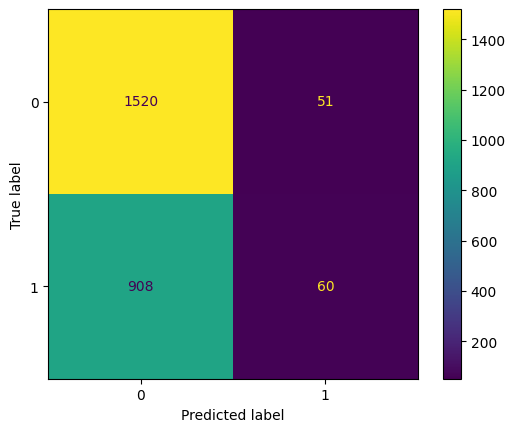

In [60]:
cross_score = lr.score(features_X_cross, target_y_cross)
print("cross set score:", cross_score)

yhat_m3 = lr.predict(features_X_cross)

accuracy_m3 = accuracy_score(target_y_cross,yhat_m3)
print('Accuracy: ', accuracy_m3)

jaccard_m3 = jaccard_score(target_y_cross, yhat_m3,pos_label=1)
print('Jaccard' , jaccard_m3)

print(metrics.classification_report(target_y_cross,yhat_m3))

# Plot the confusion matrix
cm = confusion_matrix(target_y_cross, yhat_m3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(target_y_cross))
disp.plot()

# SIMULATION PART

In [61]:
X_test_simu = X.loc[test_start:]
X_test_simu_n = normalize_data_new(X_test_simu,X_train_means,X_train_stds)

X_cross_simu = X.loc[cross_start:cross_end]
X_cross_simu_n = normalize_data_new(X_cross_simu,X_train_means,X_train_stds)

def predict_count(data_simu):
    adding = []
    for i in range(0,len(data_simu)):
        prediction = str(lsvm.predict(data_simu.iloc[i].values.reshape(1,-1))).strip('[]')
        adding.append(prediction)
    print(adding.count('0'))
    print(adding.count('1'))


print('-----cross-----')
print('The value should be:>> yhat = 0: {0}<<, >> yhat = 1: {1}<<'.format(np.count_nonzero(yhat_m1 == 0),np.count_nonzero(yhat_m1 == 1)))
predict_count(X_cross_simu_n)

print('-----test-----')
predict_count(X_test_simu_n)

-----cross-----
The value should be:>> yhat = 0: 2435<<, >> yhat = 1: 104<<
2435
104
-----test-----
1801
103


In [62]:
def predict_simu(model, data_simu_x_n, data_simu_y, initial_capital):
    capital = initial_capital
    win_count = 0
    lost_count = 0
    no_order_count = 0
    record_result = []
    record_capital = []
    record_date = []
    consecutive_lost = 0
    consecutive_lost_max = 0
    for i in range(0, len(data_simu_x_n)):
        prediction = model.predict(data_simu_x_n.iloc[i].values.reshape(1,-1))
        
        if prediction == 1 and data_simu_y[i] == 1:
            outcome = 3
            capital += outcome
            win_count += 1
            order_record = 'win-------- prediction = {0}, actual = {1}'.format(prediction,data_simu_y[i])
            result = 'win'
        elif prediction == 1 and data_simu_y[i] == 0:
            outcome = -3.3
            capital += outcome
            lost_count += 1
            order_record = 'lost------- prediction = {0}, actual = {1}'.format(prediction,data_simu_y[i])
            result = 'lost'
        elif prediction == 0:
            no_order_count +=1
            order_record = 'no order--- prediction = {0}, actual = {1}'.format(prediction, data_simu_y[i])
            capital = capital
            result = 'no order'
        else:
            raise ValueError('no condition met')
        record_date.append(data_simu_x_n.iloc[i].name)
        record_result.append(order_record)
        record_capital.append(capital)

        #Calculate Consecutive Lost
        if result == 'lost':
            consecutive_lost += -3.3
            if consecutive_lost <= consecutive_lost_max:
                consecutive_lost_max = consecutive_lost
        if result == 'win':
            if consecutive_lost <= consecutive_lost_max:
                consecutive_lost_max = consecutive_lost
            consecutive_lost = 0

    total_return = ((capital - initial_capital) / initial_capital)*100
    sim_df = pd.DataFrame({'record_date':record_date,
                           'record_result':record_result,
                           'record_capital': record_capital})
    sim_df.set_index('record_date', inplace=True)

    return win_count, lost_count, no_order_count, capital, total_return, sim_df, consecutive_lost_max


In [63]:
win_count, lost_count, no_order_count, capital, total_return, sim_df, consecutive_lost_max = predict_simu(lsvm, 
                                                                                                          X_test_simu_n, 
                                                                                                          y_test, 
                                                                                                          500)
print('Total Return: {0}%'.format(round(total_return,0)))
print('Final Capital: ${0}'.format(round(capital,0)))
print('Win Count: ',win_count)
print('Lost Count: ',lost_count)
print('No Order Count: ', no_order_count)
print('Max Consecutive Lost: {0} trades'.format(consecutive_lost_max/-3.3))
day_one = X_test_simu_n.iloc[0].name.to_pydatetime().date()
day_final = X_test_simu_n.iloc[len(X_test_simu_n)-1].name.to_pydatetime().date()
print('Total day on trading: {0} days'.format((day_final - day_one).days))

Total Return: -4.0%
Final Capital: $481.0
Win Count:  51
Lost Count:  52
No Order Count:  1801
Max Consecutive Lost: 8.000000000000002 trades
Total day on trading: 123 days


In [ ]:
X_test_simu_n.iloc[0]

In [ ]:
sim_df.plot(y='record_capital')

In [ ]:
sim_df['record_capital'].to_csv('record_capital.csv')

# Export the simulation data set:

In [ ]:
np.savetxt('y_long_simu.csv', y_test, delimiter=',')
X_test_simu_n.to_csv('X_long_simu.csv')

##### To import the file use:

```python
y_test = np.loadtxt('y_long_simu.csv', delimiter=',')
X_test_simu_n = pd.read_csv('X_long_simu.csv',index_col='datetime', parse_dates=True)
```

# Saving model using Pickle

In [ ]:
import pickle
print('version should be 4.0:',pickle.format_version)

In [ ]:
pickle.dump(lsvm,open('lsvm_xauusd_long_rrr.pkl','wb'))

In [ ]:
pickled_model=pickle.load(open('lsvm_xauusd_long_rrr.pkl','rb'))

In [ ]:
model_input = [-2.839808,-2.806494,-2.828501,-2.791640]
model_input = np.array(model_input).reshape(1,-1)
model_input
pickled_model.predict(model_input)

# Question on SVM

##### what is the different between svm.SVC(kernel='linear') and LinearSVC in sklearn?

svm.SVC(kernel='linear') and LinearSVC are both linear SVM classifiers available in scikit-learn, but there are some differences between them.

svm.SVC(kernel='linear') is based on the LIBSVM library, which is written in C++, while LinearSVC is based on the LIBLINEAR library, which is written in C.

One of the main differences between these two is the handling of multi-class classification. svm.SVC(kernel='linear') uses the one-vs-one approach, which trains a binary classifier for every pair of classes, while LinearSVC uses the one-vs-the-rest approach, which trains a binary classifier for each class against all the other classes.

Another difference is the way they handle the regularization parameter C. In svm.SVC(kernel='linear'), C controls the tradeoff between maximizing the margin and minimizing the classification error. In LinearSVC, C controls the strength of regularization, where smaller values of C lead to stronger regularization.

Overall, LinearSVC is faster and more memory-efficient than svm.SVC(kernel='linear') and is recommended for large datasets with many features, while svm.SVC(kernel='linear') may be more suitable for smaller datasets with few features or for multi-class classification.

##### which is created first

SVC(kernel='linear') was created first and it is a more flexible implementation of linear support vector machines. It can handle non-linearly separable data by using the kernel trick to transform the input data into a higher-dimensional feature space where the data becomes linearly separable.

LinearSVC, on the other hand, is a more efficient implementation of linear support vector machines that only supports linear kernels. It uses a different algorithm for training the model that is more scalable and faster than the algorithm used by SVC(kernel='linear').

Both models are useful for solving binary classification problems, but LinearSVC is generally preferred when the dataset is large and the number of features is high, while SVC(kernel='linear') is preferred when the dataset is smaller or when non-linearly separable data is involved.

##### Definition of large dataset and high number of features

The definitions of "large dataset" and "high number of features" are somewhat relative and can vary depending on the context of the problem and the available computational resources. However, as a general rule of thumb, a "large dataset" can refer to a dataset with tens of thousands or more samples, while a "small dataset" can refer to a dataset with a few hundred or a few thousand samples.

Similarly, a "high number of features" can also be relative, but it generally refers to datasets where the number of features is comparable to or larger than the number of samples. For example, in genomics and bioinformatics, it is common to work with datasets with tens of thousands or even hundreds of thousands of features.

In practice, when working with a large dataset with a high number of features, LinearSVC can be more computationally efficient and can handle such datasets more effectively. On the other hand, when working with a smaller dataset with a lower number of features, SVC(kernel='linear') can perform just as well and may offer better accuracy in some cases.b

# Question XGBoost

Random Forest and XGBoost are both popular machine learning algorithms used for regression and classification tasks. However, there are several key differences between these algorithms, which are outlined below:

**During the training process**, XGBoost uses gradient boosting to optimize a loss function. The loss function measures the difference between the predicted and actual values and is chosen based on the specific problem being solved. For example, the mean squared error (MSE) loss function can be used for regression problems, and the cross-entropy loss function can be used for classification problems.

**Model architecture:** Random Forest is an ensemble learning method that builds multiple decision trees and combines their predictions to make a final prediction. Each decision tree in the Random Forest is built independently and does not depend on the other trees. On the other hand, XGBoost is a boosted tree algorithm that builds decision trees sequentially, where each new tree corrects the errors of the previous trees.

**Tree construction:** In Random Forest, each decision tree is built by randomly selecting a subset of the features and the samples in the training set. This helps to reduce overfitting and improves the performance of the model. In XGBoost, each tree is built by greedily selecting the best split that maximizes the information gain.

**Handling of missing data:** Random Forest can handle missing data by imputing the missing values with the mean or median of the feature. XGBoost can handle missing data by splitting the samples into two groups: one group with the missing value and one group without the missing value.

**Regularization:** Random Forest does not have any regularization parameters. XGBoost has several regularization parameters, including the learning rate, which controls the step size during the gradient descent, and the regularization term, which penalizes complex models and helps to prevent overfitting.

**Performance:** Random Forest is generally faster to train than XGBoost, especially for large datasets. However, XGBoost often outperforms Random Forest in terms of predictive accuracy, especially for complex tasks with high-dimensional features.

**In summary,** Random Forest and XGBoost are both powerful machine learning algorithms with different strengths and weaknesses. Random Forest is a simple and fast algorithm that can handle missing data, while XGBoost is a more complex algorithm that can handle complex tasks and has better predictive accuracy, but may require more tuning and training time.

